# Large-scale multi-label text classification
**Description:** Implementing a large-scale multi-label text classification model.

## Introduction

In this example, we will build a multi-label text classifier to predict the subject areas
of arXiv papers from their abstract bodies. This type of classifier can be useful for
conference submission portals like [OpenReview](https://openreview.net/). Given a paper
abstract, the portal could provide suggestions for which areas the paper would
best belong to.

The dataset was collected using the
[`arXiv` Python library](https://github.com/lukasschwab/arxiv.py)
that provides a wrapper around the
[original arXiv API](http://arxiv.org/help/api/index).

## Imports

import libraries

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Perform exploratory data analysis

In this section, we first load the dataset into a `pandas` dataframe and then perform
some basic exploratory data analysis (EDA).

read data from csv file and print first 5 rows of dataframe

In [ ]:
arxiv_data = pd.read_csv(
    "arxiv_data.csv"
)
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


Our text features are present in the `summaries` column and their corresponding labels
are in `terms`. As you can notice, there are multiple categories associated with a
particular entry.

count the number of rows of the dataframe

In [ ]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 51774 rows in the dataset.


Real-world data is noisy. One of the most commonly observed source of noise is data
duplication. Here we notice that our initial dataset has got about 13k duplicate entries.

count the number of duplicate titles

In [ ]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 12802 duplicate titles.


Before proceeding further, we drop these entries.

removes duplicated rows in a dataset called "arxiv_data" based on the "titles" column, and then prints the number of rows in the deduplicated dataset, the count of terms with occurrence as low as 1, and the number of unique terms in the "terms" column.

In [ ]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 38972 rows in the deduplicated dataset.
2321
3157


As observed above, out of 3,157 unique combinations of `terms`, 2,321 entries have the
lowest occurrence. To prepare our train, validation, and test sets with
[stratification](https://en.wikipedia.org/wiki/Stratified_sampling), we need to drop
these terms.

The code filters a dataset called "arxiv_data" based on the "terms" column, keeping only the rows with terms that appear more than once, and then prints the shape of the resulting dataset "arxiv_data_filtered".

In [ ]:
# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

## Convert the string labels to lists of strings

The initial labels are represented as raw strings. Here we make them `List[str]` for a
more compact representation.

The code applies the function literal_eval() to the "terms" column of the dataset "arxiv_data_filtered", which converts strings that look like lists into actual lists, and then prints the first 5 values of the "terms" column.

In [ ]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

## Use stratified splits because of class imbalance

The dataset has a
[class imbalance problem](https://developers.google.com/machine-learning/glossary/#class-imbalanced-dataset).
So, to have a fair evaluation result, we need to ensure the datasets are sampled with
stratification. To know more about different strategies to deal with the class imbalance
problem, you can follow
[this tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
For an end-to-end demonstration of classification with imbablanced data, refer to
[Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/).

The code defines a test_split variable and then splits the "arxiv_data_filtered" dataset into train and test sets using train_test_split() function, where the test set is further split into a validation set and a new test set. Finally, the code prints the number of rows in each of the resulting sets.

In [ ]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


## Multi-label binarization

Now we preprocess our labels using the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer.

The code creates a ragged tensor called "terms" based on the "terms" column of the "train_df" dataset, and then creates a StringLookup layer called "lookup" that encodes the terms as multi-hot vectors. The code adapts the lookup layer to the terms tensor and obtains the vocabulary from it. Finally, the code defines a function that can reverse the encoding and print the resulting vocabulary.

In [ ]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.CG', 'cs.NI', 'cs.SE', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cs.PL', 'cond-mat.dis-nn', '68T45', 'math.PR', 'physics.comp-ph', 'I.2.10', 'cs.CE', 'cs.AR', 'q-fin.ST', 'cond-mat.stat-mech', '68T05', 'quant-ph', 'math.DS', 'cs.CC', 'I.4.6', 'physics.data-an', 'physics.soc-ph', 'physics.ao-ph', 'econ.EM', 'cs.DM', 'q-bio.GN', 'physics.med-ph', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.PF', 'cs.FL', 'I.4', 'q-fin.TR', 'I.5.4', 'I.2', '68U10', 'physics.geo-ph', 'hep-ex', 'cond-mat.mtrl-sci', '68T10', 'q-fin.CP', 'physics.optics', 'physics.flu-dyn', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6; I.2.8', '

Here we are separating the individual unique classes available from the label
pool and then using this information to represent a given label set with 0's and 1's.
Below is an example.

The code defines a variable called "sample_label" as the first label in the "terms" column of the "train_df" dataset, and prints it. The code then applies the lookup layer to the sample_label to convert it to its multi-hot encoded representation, and prints the resulting encoded representation.





In [ ]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.LG']
Label-binarized representation: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Data preprocessing and `tf.data.Dataset` objects

We first get percentile estimates of the sequence lengths. The purpose will be clear in a
moment.

The code applies a lambda function to the "summaries" column of the "train_df" dataset, which splits each summary into words and calculates the length of each summary in terms of the number of words. Finally, the code computes and prints summary statistics (count, mean, standard deviation, minimum, and maximum) for the resulting lengths.

In [ ]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    32985.000000
mean       156.507594
std         41.516743
min          5.000000
25%        128.000000
50%        155.000000
75%        183.000000
max        297.000000
Name: summaries, dtype: float64

Notice that 50% of the abstracts have a length of 154 (you may get a different number
based on the split). So, any number close to that value is a good enough approximate for the
maximum sequence length.

Now, we implement utilities to prepare our datasets.

The code defines the maximum sequence length and batch size, and a padding token for creating a dataset. It then defines a function called "make_dataset" that takes a dataframe as input and creates a dataset by encoding the "terms" column as multi-hot vectors using the lookup layer, and then combining it with the "summaries" column. Finally, the function returns a batched dataset.

In [ ]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


Now we can prepare the `tf.data.Dataset` objects.

The code creates three datasets for training, validation, and testing by calling the "make_dataset" function with the corresponding dataframes and a boolean flag to specify whether the dataset is for training or not.

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Dataset preview

The code generates a batch of text and label pairs from the "train_dataset" using the "next" function and prints the first 5 pairs. For each pair, the code extracts the text and multi-hot encoded label, converts the label back to the corresponding terms using the "invert_multi_hot" function, and then prints the text and label in human-readable form.

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'We propose an efficient transfer learning method for adapting ImageNet\npre-trained Convolutional Neural Network (CNN) to fine-grained image\nclassification task. Conventional transfer learning methods typically face the\ntrade-off between training time and accuracy. By adding "attention module" to\neach convolutional filters of the pre-trained network, we are able to rank and\nadjust the importance of each convolutional signal in an end-to-end pipeline.\nIn this report, we show our method can adapt a pre-trianed ResNet50 for a\nfine-grained transfer learning task within few epochs and achieve accuracy\nabove conventional transfer learning methods and close to models trained from\nscratch. Our model also offer interpretable result because the rank of the\nconvolutional signal shows which convolution channels are utilized and\namplified to achieve better classification result, as well as which signal\nshould be treated as noise for the specific transfer learning task, which 

## Vectorization

Before we feed the data to our model, we need to vectorize it (represent it in a numerical form).
For that purpose, we will use the
[`TextVectorization` layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).
It can operate as a part of your main model so that the model is excluded from the core
preprocessing logic. This greatly reduces the chances of training / serving skew during inference.

We first calculate the number of unique words present in the abstracts.

The code creates a set of words called "vocabulary" by splitting the text in the "summaries" column of the "train_df" dataframe, converting them to lower case, and updating the set. Then, it prints the size of the vocabulary.

In [ ]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)


153236


We now create our vectorization layer and `map()` to the `tf.data.Dataset`s created
earlier.

This code initializes a TextVectorization layer with a specific configuration and adapts it to the vocabulary from the training set. It then applies the TextVectorization layer to the text data in the training, validation, and test datasets and prefetches them for performance optimization.





In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


A batch of raw text will first go through the `TextVectorization` layer and it will
generate their integer representations. Internally, the `TextVectorization` layer will
first create bi-grams out of the sequences and then represent them using
[TF-IDF](https://wikipedia.org/wiki/Tf%E2%80%93idf). The output representations will then
be passed to the shallow model responsible for text classification.

To learn more about other possible configurations with `TextVectorizer`, please consult
the
[official documentation](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).

**Note**: Setting the `max_tokens` argument to a pre-calculated vocabulary size is
not a requirement.

## Create a text classification model

We will keep our model simple -- it will be a small stack of fully-connected layers with
ReLU as the non-linearity.

This code defines a shallow multi-layer perceptron (MLP) model with three dense layers. The first two layers have 512 and 256 neurons, respectively, and the output layer has a number of neurons equal to the size of the vocabulary. The activation function used in the output layer is sigmoid.

In [ ]:

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


## Train the model

We will train our model using the binary crossentropy loss. This is because the labels
are not disjoint. For a given abstract, we may have multiple categories. So, we will
divide the prediction task into a series of multiple binary classification problems. This
is also why we kept the activation function of the classification layer in our model to
sigmoid. Researchers have used other combinations of loss function and activation
function as well. For example, in [Exploring the Limits of Weakly Supervised Pretraining](https://arxiv.org/abs/1805.00932),
Mahajan et al. used the softmax activation function and cross-entropy loss to train
their models.

There are several options of metrics that can be used in multi-label classification.
To keep this code example narrow we decided to use the
[binary accuracy metric](https://keras.io/api/metrics/accuracy_metrics/#binaryaccuracy-class).
To see the explanation why this metric is used we refer to this
[pull-request](https://github.com/keras-team/keras-io/pull/1133#issuecomment-1322736860).
There are also other suitable metrics for multi-label classification, like
[F1 Score](https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score) or
[Hamming loss](https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/HammingLoss).

This code trains a shallow multi-layer perceptron model with binary cross-entropy loss and Adam optimizer on the training dataset, evaluates it on the validation dataset, and plots the training and validation loss and binary accuracy over epochs for 10 epochs.





Epoch 1/10
258/258 [==============================] - 28s 82ms/step - loss: 0.0340 - binary_accuracy: 0.9886 - val_loss: 0.0188 - val_binary_accuracy: 0.9942
Epoch 2/10
258/258 [==============================] - 19s 75ms/step - loss: 0.0033 - binary_accuracy: 0.9990 - val_loss: 0.0260 - val_binary_accuracy: 0.9940
Epoch 3/10
258/258 [==============================] - 21s 79ms/step - loss: 8.6151e-04 - binary_accuracy: 0.9998 - val_loss: 0.0331 - val_binary_accuracy: 0.9939
Epoch 4/10
258/258 [==============================] - 20s 76ms/step - loss: 3.4998e-04 - binary_accuracy: 0.9999 - val_loss: 0.0376 - val_binary_accuracy: 0.9939
Epoch 5/10
258/258 [==============================] - 20s 78ms/step - loss: 1.9887e-04 - binary_accuracy: 1.0000 - val_loss: 0.0404 - val_binary_accuracy: 0.9939
Epoch 6/10
258/258 [==============================] - 21s 81ms/step - loss: 1.2460e-04 - binary_accuracy: 1.0000 - val_loss: 0.0432 - val_binary_accuracy: 0.9940
Epoch 7/10
258/258 [================

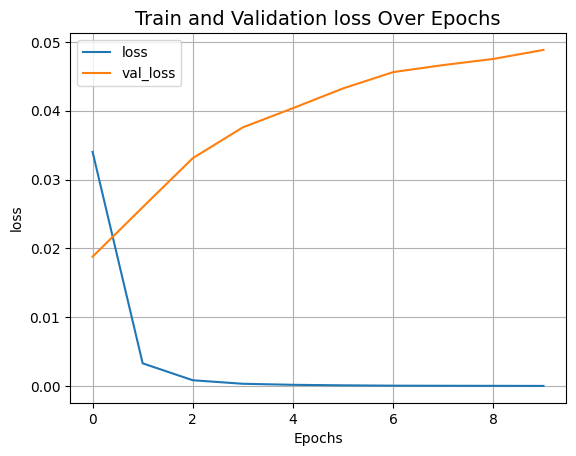

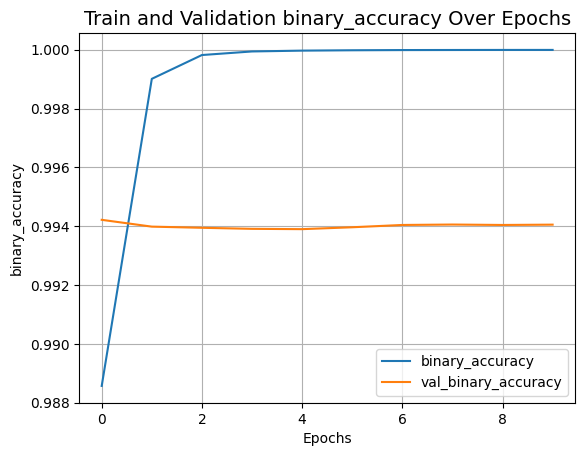

In [ ]:
epochs = 10

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

While training, we notice an initial sharp fall in the loss followed by a gradual decay.

### Evaluate the model

This code evaluates the performance of the trained model on the test dataset and prints out the binary accuracy score rounded off to two decimal places.





In [ ]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

15/15 [==============================] - 1s 56ms/step - loss: 0.0473 - binary_accuracy: 0.9940
Categorical accuracy on the test set: 99.4%.


The trained model gives us an evaluation accuracy of ~99%.

## Inference

An important feature of the
[preprocessing layers provided by Keras](https://keras.io/guides/preprocessing_layers/)
is that they can be included inside a `tf.keras.Model`. We will export an inference model
by including the `text_vectorization` layer on top of `shallow_mlp_model`. This will
allow our inference model to directly operate on raw strings.

**Note** that during training it is always preferable to use these preprocessing
layers as a part of the data input pipeline rather than the model to avoid
surfacing bottlenecks for the hardware accelerators. This also allows for
asynchronous data processing.

This code creates a model for inference by combining the text vectorization layer and the trained shallow MLP model. It then uses a small dataset to perform inference by predicting probabilities of the top three predicted labels for each abstract in the dataset.





In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

4/4 [==============================] - 0s 11ms/step
Abstract: b'The semantic segmentation of parts of objects in the wild is a challenging\ntask in which multiple instances of objects and multiple parts within those\nobjects must be detected in the scene. This problem remains nowadays very\nmarginally explored, despite its fundamental importance towards detailed object\nunderstanding. In this work, we propose a novel framework combining higher\nobject-level context conditioning and part-level spatial relationships to\naddress the task. To tackle object-level ambiguity, a class-conditioning module\nis introduced to retain class-level semantics when learning parts-level\nsemantics. In this way, mid-level features carry also this information prior to\nthe decoding stage. To tackle part-level ambiguity and localization we propose\na novel adjacency graph-based module that aims at matching the relative spatial\nrelationships between ground truth and predicted parts. The experimental\nevalua

The prediction results are not that great but not below the par for a simple model like
ours. We can improve this performance with models that consider word order like LSTM or
even those that use Transformers ([Vaswani et al.](https://arxiv.org/abs/1706.03762)).